In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import tensorflow as tf
from sklearn.metrics import mean_absolute_error as mae

# Model Import
### 2D U-Net CNN which takes input images of shape (448x24)

In [26]:
model = tf.keras.models.load_model('near_offset_cnn_cdp_448x24.h5')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 448, 24, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 448, 24, 16)  160         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 448, 24, 16)  2320        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 224, 12, 16)  0           ['conv2d_1[0][0]']           

# Example Predictions on Source-over-cable Field Gathers

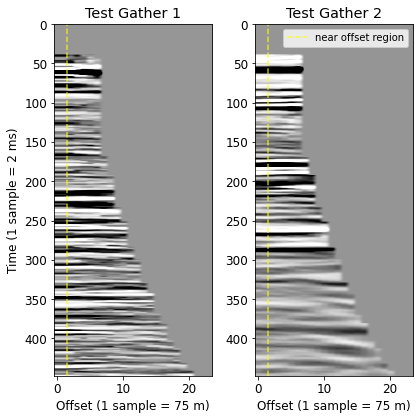

In [28]:
# load two example gathers
gather1 = np.load('gather_ex1.npy')
gather2 = np.load('gather_ex2.npy')

plt.rcParams.update({'font.size': 12})
fig,ax = plt.subplots(1, 2, figsize=(6,6))
c1 = 5e-2
c2 = 7e-2
vline = 1.5

ax[0].imshow(gather1, aspect='auto', cmap='Greys', vmin=-c1, vmax=c1)
ax[0].set_xlabel('Offset (1 sample = 75 m)')
ax[0].set_ylabel('Time (1 sample = 2 ms)')
ax[0].set_title('Test Gather 1')
ax[0].axvline(x=vline, color='yellow', linestyle='--', alpha=0.7)

ax[1].imshow(gather2, aspect='auto', cmap='Greys', vmin=-c2, vmax=c2)
ax[1].set_xlabel('Offset (1 sample = 75 m)')
ax[1].set_title('Test Gather 2')
ax[1].axvline(x=vline, color='yellow', linestyle='--', alpha=0.7, label='near offset region')
ax[1].legend(fontsize=10)

plt.tight_layout()

### Data preparation and prediction process

In [29]:
gather1_input = np.copy(gather1)
gather2_input = np.copy(gather2)

# zero out first two traces (0th and 1st; 112.5 meters of offset) for input to model
gather1_input[:, :2] = 0
gather2_input[:, :2] = 0

# expand dimensions to shape (1, 448, 24, 1) for compatibility with Tensorflow
gather1_input = np.expand_dims(gather1_input, axis=2)
gather1_input = np.expand_dims(gather1_input, axis=0)

gather2_input = np.expand_dims(gather2_input, axis=2)
gather2_input = np.expand_dims(gather2_input, axis=0)

# make predictions with model
ypred1 = model.predict(gather1_input, verbose=False)
ypred2 = model.predict(gather2_input, verbose=False)

# extract predictions in (448,24) shape
ypred1 = ypred1[0,:,:,0]
ypred2 = ypred2[0,:,:,0]

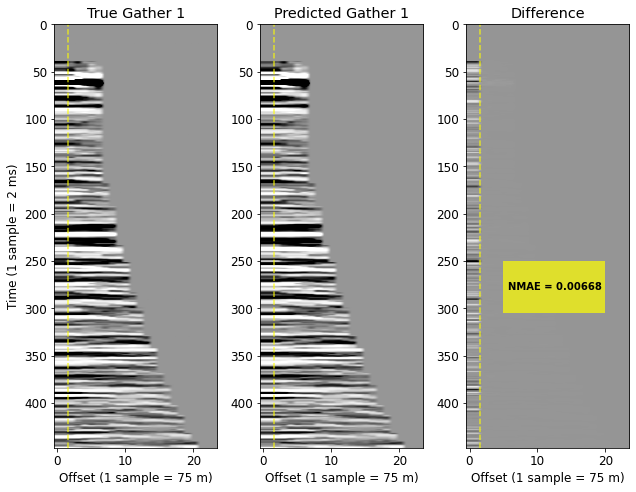

In [30]:
fig,ax = plt.subplots(1, 3, figsize=(9,7))

# Plot True Gather
ax[0].imshow(gather1, aspect='auto', cmap='Greys', vmin=-c1, vmax=c1)
ax[0].axvline(x=vline, color='yellow', linestyle='--', alpha=0.7)
ax[0].set_xlabel('Offset (1 sample = 75 m)')
ax[0].set_ylabel('Time (1 sample = 2 ms)')
ax[0].set_title('True Gather 1')

# Plot Predicted Gather
ax[1].imshow(ypred1, aspect='auto', cmap='Greys', vmin=-c1, vmax=c1)
ax[1].axvline(x=vline, color='yellow', linestyle='--', alpha=0.7)
ax[1].set_xlabel('Offset (1 sample = 75 m)')
ax[1].set_title('Predicted Gather 1')

# Plot Difference
diff1 = gather1 - ypred1
ax[2].imshow(diff1, aspect='auto', cmap='Greys', vmin=-c1, vmax=c1)
ax[2].axvline(x=vline, color='yellow', linestyle='--', alpha=0.7)
ax[2].set_xlabel('Offset (1 sample = 75 m)')
ax[2].set_title('Difference')

# calculate normalized mean absolute error (NMAE) between true gather and prediction
error1 = round(mae(gather1[:,:2], ypred1[:,:2]) / 
     (np.max(gather1[:,:2])-np.min(gather1[:,:2])), 5)
rect = patches.Rectangle((5,250), 15, 55, linewidth=7, facecolor='yellow', edgecolor=None, alpha=0.7)
ax[2].add_patch(rect)
rx, ry = rect.get_xy()
cx = rx + rect.get_width()/2.0
cy = ry + rect.get_height()/2.0
ax[2].annotate("NMAE = "+str(error1), (cx,cy), color='black', weight='bold', fontsize=10, ha='center', va='center')
plt.tight_layout()

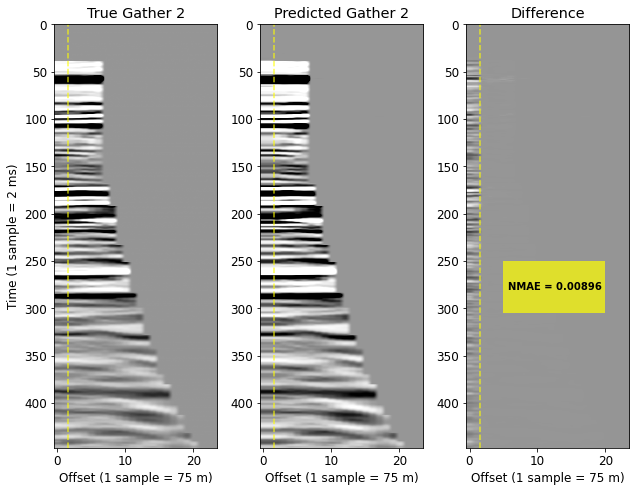

In [31]:
fig,ax = plt.subplots(1, 3, figsize=(9,7))

# Plot True Gather
ax[0].imshow(gather2, aspect='auto', cmap='Greys', vmin=-c2, vmax=c2)
ax[0].axvline(x=vline, color='yellow', linestyle='--', alpha=0.7)
ax[0].set_xlabel('Offset (1 sample = 75 m)')
ax[0].set_ylabel('Time (1 sample = 2 ms)')
ax[0].set_title('True Gather 2')

# Plot Predicted Gather
ax[1].imshow(ypred2, aspect='auto', cmap='Greys', vmin=-c1, vmax=c1)
ax[1].axvline(x=vline, color='yellow', linestyle='--', alpha=0.7)
ax[1].set_xlabel('Offset (1 sample = 75 m)')
ax[1].set_title('Predicted Gather 2')

# Plot Difference
diff2 = gather2 - ypred2
ax[2].imshow(diff2, aspect='auto', cmap='Greys', vmin=-c2, vmax=c2)
ax[2].axvline(x=vline, color='yellow', linestyle='--', alpha=0.7)
ax[2].set_xlabel('Offset (1 sample = 75 m)')
ax[2].set_title('Difference')

# calculate normalized mean absolute error (NMAE) between true gather and prediction
error2 = round(mae(gather2[:,:2], ypred2[:,:2]) / 
     (np.max(gather2[:,:2])-np.min(gather2[:,:2])), 5)
rect = patches.Rectangle((5,250), 15, 55, linewidth=7, facecolor='yellow', edgecolor=None, alpha=0.7)
ax[2].add_patch(rect)
rx, ry = rect.get_xy()
cx = rx + rect.get_width()/2.0
cy = ry + rect.get_height()/2.0
ax[2].annotate("NMAE = "+str(error2), (cx,cy), color='black', weight='bold', fontsize=10, ha='center', va='center')
plt.tight_layout()

#  A few practical notes if using on other datasets

### * Gathers here were cropped to have the water bottom start at 50 time samples, and were muted beyond 35 degrees. Consider doing something similar on your dataset.

### *  Gathers should first be normalized by the maximum amplitude among your collection of gathers
        for example: gathers_norm = gathers/np.max(gathers)
        
### * If using conventional data, the gathers should be padded with 2 zeros in the offset dimension, like:
        gather_padded = np.pad(gather, ((0, 0), (2, 0)), mode='constant', constant_values=0)
        
### *  After prediction, you should concatenate the predicted near offset region to the original farther offsets, since there is small prediction error in the area at farther offsets
        an example of this is shown below

In [32]:
ypred2_concat = np.concatenate((ypred2[:, :2], gather2[:, 2:]), axis=1)

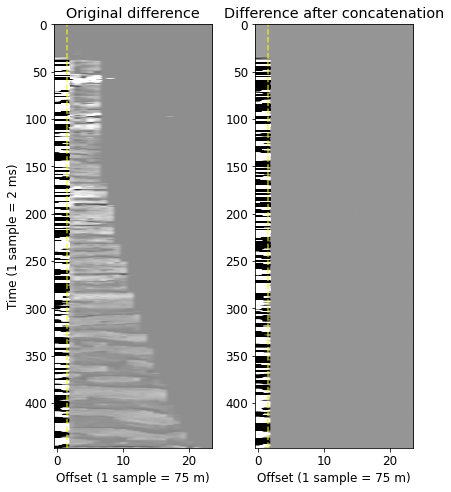

In [33]:
fig,ax = plt.subplots(1, 2, figsize=(6,7))

# Scaled up Prediction Error
c_scaled = 1e-3
ax[0].imshow(diff2, aspect='auto', cmap='Greys', vmin=-c_scaled, vmax=c_scaled)
ax[0].axvline(x=vline, color='yellow', linestyle='--', alpha=0.7)
ax[0].set_xlabel('Offset (1 sample = 75 m)')
ax[0].set_ylabel('Time (1 sample = 2 ms)')
ax[0].set_title('Original difference')

# Error after concatenating prediction to original farther offsets
diff_concat = ypred2_concat - gather2
ax[1].imshow(diff_concat, aspect='auto', cmap='Greys', vmin=-c_scaled, vmax=c_scaled)
ax[1].axvline(x=vline, color='yellow', linestyle='--', alpha=0.7)
ax[1].set_xlabel('Offset (1 sample = 75 m)')
ax[1].set_title('Difference after concatenation')

plt.tight_layout()
